In [9]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import os
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#os.chdir(os.pardir)

In [3]:
os.getcwd()

'c:\\Users\\dwarf\\Dataproject'

In [30]:
#os.chdir("C:\\Users\\dwarf\\Dataproject")

In [4]:
k_mers = ["2","2","4","4","6","6"]
checks = [True,False,True,False,True,False]
colors = ["b","g","r","c","m","y"]
model_probs = []

In [5]:
def pca(train_data, test_data): 
        dim_reduction = PCA()
        train_fit = dim_reduction.fit_transform(train_data)
        test_fit = dim_reduction.transform(test_data)
        return [train_fit, test_fit]

In [6]:
def pca2(X, comp = None): 
        dim_reduction = PCA(n_components=comp)
        X = dim_reduction.fit_transform(X)
        return [X]

In [7]:
Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[0] + "mers_meth_with_background.tsv", sep="\t")
Meth = Meth.drop(306)
cancer_list = []
for j in range(0,306):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)

for j in range(307,len(Meth)+1):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)
Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[0] + "mers_unmeth_with_background.tsv", sep="\t")
Unmeth = Unmeth.drop(306)

for j in range(0,306):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)

for j in range(307,len(Unmeth)+1):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)


In [39]:
print(len(cancer_list))

948


In [23]:
results = []
model_probs = []
for i in range(len(k_mers)):

    #os.chdir(os.pardir)
    Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_meth_with_background.tsv", sep="\t")
    Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_unmeth_with_background.tsv", sep="\t")
    Meth = Meth.drop(306)
    Unmeth = Unmeth.drop(306)
    Combined = [Meth,Unmeth]
    Healthy_Meth = Meth.loc[Meth["cancer"]=="Healthy"]
    Healthy_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Data0 = Healthy_Meth
    Data1 = Healthy_Unmeth
    Combined = [Data0,Data1]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]
    dim_reduction = PCA()
    y = [0] * Data0.shape[0] + [1] * Data1.shape[0]
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train = dim_reduction.fit_transform(X_train)
    X_test = dim_reduction.transform(X_test)

    # Create a pipeline with standardization and logistic regression with L1 regularization
    pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000))
    # Define hyperparameters grid for GridSearchCV
    param_grid = {
        'logisticregression__C': np.logspace(-3, 1, 100)  # Values for regularization parameter C
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)



    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    num_selected_variables = np.sum(best_model.named_steps['logisticregression'].coef_ != 0)

    results.append([test_accuracy, grid_search.best_params_["logisticregression__C"], num_selected_variables,[k_mers[i],checks[i]]])


    plt.scatter(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors[i])
    plt.plot(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors [i])
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.savefig("Cross_Val " + k_mers[i] + "-mer, PCA = " + str(checks[i]))
    plt.close()
    
    Data0 = Meth
    Data1 = Unmeth
    Combined = [Data0,Data1]
    X2 = pd.concat(Combined)
    X2 = X2.iloc [:, :-1]
    X2 = dim_reduction.transform(X2)
    probs = grid_search.predict_proba(X2)
    y = [0] * Data0.shape[0] + [1] * Data1.shape[0]
    Meth_h_probs = []
    Unmeth_h_probs = []
    Meth_c_probs = []
    Unmeth_c_probs = []
    for j in range(len(probs)):
        if y[j] == 0 and cancer_list[j] == 1:
            Meth_h_probs.append(probs[j][0])
        elif y[j] == 0 and cancer_list[j] == 0:
            Meth_c_probs.append(probs[j][0])
        elif y[j] == 1 and cancer_list[j] == 1:
            Unmeth_h_probs.append(probs[j][1])
        elif y[j] == 1 and cancer_list[j] == 0:
            Unmeth_c_probs.append(probs[j][1])
    model_probs.append([[Meth_h_probs,Unmeth_h_probs],[Meth_c_probs,Unmeth_c_probs]])


    print("Best model:", best_model)
    print("Best parameter (C):", grid_search.best_params_)
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)



Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.10476157527896651, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 0.10476157527896651}
Train accuracy: 1.0
Test accuracy: 1.0
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.2009233002565048, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 0.2009233002565048}
Train accuracy: 1.0
Test accuracy: 1.0
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5094138014816381, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregre

In [23]:
grid_search.predict_proba(X)

array([[9.99593526e-01, 4.06474269e-04],
       [9.99998192e-01, 1.80826277e-06],
       [9.98835331e-01, 1.16466855e-03],
       ...,
       [1.31391542e-03, 9.98686085e-01],
       [1.70125427e-03, 9.98298746e-01],
       [4.33819035e-05, 9.99956618e-01]])

In [51]:
print(len(probs))

948


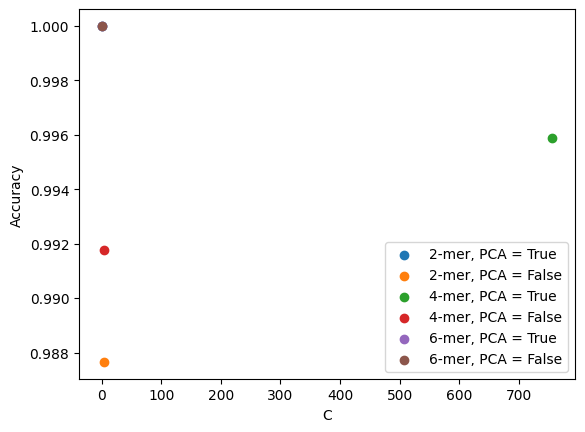

In [16]:
for i in range(len(results)):
    plt.scatter(results[i][1],results[i][0],label=results[i][3][0] + "-mer, PCA = " + str(results[i][3][1]))
plt.legend() 
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("Cross_Val")

In [37]:
C = []
N_var = []
Acc = []
k_mer = []
princ = []
for i in range(len(results)):
    C.append(results[i][1])
    Acc.append(results[i][0])
    N_var.append(results[i][2])
    k_mer.append(results[i][3][0])
    princ.append(results[i][3][1])
Extra = pd.DataFrame({'k-mer':k_mer, 'PCA': princ, 'C': C, 'Accuracy': Acc, 'Number of variables': N_var})

In [38]:
Extra

,k-mer,PCA,C,Accuracy,Number of variables
0,2,True,0.104762,1.000000,7
1,2,False,0.200923,1.000000,12
2,4,True,0.509414,0.991770,19
3,4,False,0.138489,0.975309,7
4,6,True,0.010235,1.000000,1
5,6,False,0.010235,1.000000,1


In [48]:
len(model_probs)
model_probs[0][0][0]

[0.9863234976295867,
 0.7460796630066089,
 0.9946786984595309,
 0.8089596257321445,
 0.9751847336803895,
 0.0027649741786203164,
 0.7235303972825015,
 0.6920952251451715,
 0.6525585185644177,
 0.6373340739123502,
 0.32641816144275415,
 0.037531169690536825,
 0.028938503449713826,
 0.1570354941645259,
 0.09291241927264393,
 0.3563063271959477,
 0.8506069735782363,
 0.7694438805706274,
 0.6735744141822677,
 0.37377738482000256,
 0.9627837466983918,
 0.6436217943052185,
 0.9629515824396669,
 0.11716723198734946,
 0.6732882638166787,
 0.01281149607238874,
 0.6778241591634682,
 0.8418763572756964,
 0.5201313539151458,
 0.0006382051052840065,
 0.7850953467513035,
 0.1669546928145682,
 0.44183363101955797,
 0.014225467626994837,
 0.9372000072878574,
 0.878883603825123,
 0.712329897509699,
 0.9955588480849019,
 0.9863410753091707,
 0.007320616251839329,
 0.7147222501782431,
 0.7332106074572027,
 0.4416879435592663,
 0.9999288002355688,
 0.9497047526090487,
 0.47002019157772124,
 0.689926441701

In [42]:
methylation = ["Methylated","Unmethylated"]
cancers = ["Noncancer","Cancer"]

for i in range(len(model_probs)):
    for j in range(len(model_probs[i])):
        for l in range(len(model_probs[i][j])):
            print(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l] + " Avg prediction = " + str(np.mean(model_probs[i][j][l])))
            #print(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot=sns.displot(x=model_probs[i][j][l])
            #plt.hist(x=model_probs[i][j][l])
            #plt.title(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #plt.savefig(fname=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot.set(title=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot.figure.savefig(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l]+".png")


2-mer, PCA = True, Noncancer Methylated Avg prediction = 0.8940502699881313
2-mer, PCA = True, Noncancer Unmethylated Avg prediction = 0.8724335205709768
2-mer, PCA = True, Cancer Methylated Avg prediction = 0.807441038505442
2-mer, PCA = True, Cancer Unmethylated Avg prediction = 0.7990013664618959
2-mer, PCA = False, Noncancer Methylated Avg prediction = 0.914198190695566
2-mer, PCA = False, Noncancer Unmethylated Avg prediction = 0.9448118159386298
2-mer, PCA = False, Cancer Methylated Avg prediction = 0.8597474245173456
2-mer, PCA = False, Cancer Unmethylated Avg prediction = 0.8560681472965466
4-mer, PCA = True, Noncancer Methylated Avg prediction = 0.964740059219142
4-mer, PCA = True, Noncancer Unmethylated Avg prediction = 0.9638311956511558
4-mer, PCA = True, Cancer Methylated Avg prediction = 0.9531350206106833
4-mer, PCA = True, Cancer Unmethylated Avg prediction = 0.9037877086065819
4-mer, PCA = False, Noncancer Methylated Avg prediction = 0.9025305999476123
4-mer, PCA = Fal

In [10]:
model_probs[0][1][1]

[0.018939482441177786,
 0.8612082639524419,
 0.5102782809445333,
 0.9978752359936668,
 0.11115238425664213,
 0.999612969352024,
 0.9769314670510449,
 0.8839156891023658,
 0.8186292250448765,
 0.8098597186192922,
 0.8691964183504461,
 0.9808332701104369,
 0.3509288725379255,
 0.9886748746864449,
 0.9593523815372343,
 0.756668006854927,
 0.9913229891881307,
 0.9937862322717108,
 0.9421622893199211,
 0.9846103387234627,
 0.9821546748497735,
 0.0670458070154005,
 0.025272019630943506,
 0.9932039173937323,
 0.716343099173791,
 0.9894796055000277,
 0.8489351155328198,
 0.6757961468682059,
 0.9355149923019,
 0.9991673827316169,
 0.7291781561197972,
 0.9571554707112363,
 0.991113492568146,
 0.9865290425140726,
 0.17219013139183836,
 0.2586277239454915,
 0.5050726801277041,
 0.02745158162552313,
 0.0684573875507577,
 0.9906163051445277,
 0.30433856660207287,
 0.4148680910355727,
 0.4029981157409396,
 0.0008345979791933648,
 0.16164221458403025,
 0.8203093870148013,
 0.9208226692175379,
 0.02645

TypeError: unhashable type: 'list'

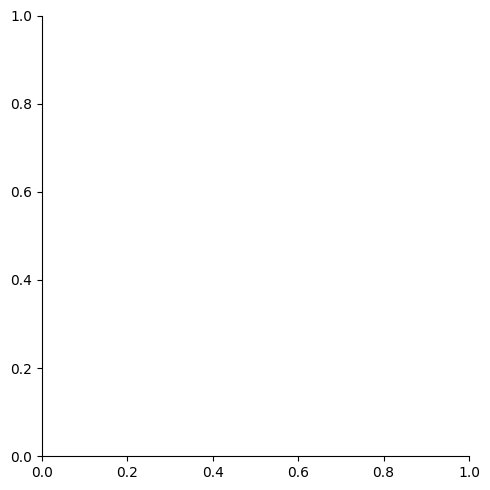